In [17]:
# i have no idea just have the following dataset downloaded
#https://www.kaggle.com/datasets/thoughtvector/customer-support-on-twitter
# project assumes you have a folder called "archive.zip" in the same directory as this file
# and that is is indeed downloaded from the above link

#!pip install kaggle

# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d thoughtvector/customer-support-on-twitter

In [18]:
#!pip install matplotlib
#!pip install pandas
#!pip install numpy
#!pip install tensorflow
#!pip install keras
#!pip install nltk


import zipfile

#data wranglers
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import keras

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

#nl libraries
import string 
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download("vader_lexicon")
nltk.download("punkt")

#data visualization
import sklearn
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\annae\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\annae\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [19]:
#unzip the file
zipped=zipfile.ZipFile('archive.zip')
data=pd.read_csv(zipped.open('twcs/twcs.csv'))

#look at data
# print(data.shape)
# data.head()

#drop unnecessary columns
df=data.drop(['inbound', 'created_at'],axis=1)
df['text']=df['text'].astype(str)
df.sample(frac=1)
df=df.head(50000)
#df=df.head()

df.shape

(50000, 5)

In [20]:

#remove company info from data
def rmcompanies(df):
    #takes in a data frame
    #returns data frame without rows with author containing letters
    idx=[]
    #find row id of authors with letters in name
    for id in range(len(df['author_id'])):
        if(any(ch.isalpha() for ch in df['author_id'][id])):
            idx.append(id)
    
    #drop rows with companies
    return df.drop(idx)


In [21]:
#get rid of company data 
customers=rmcompanies(df)

#do sentiment analysis on the text
sent_analyzer=SentimentIntensityAnalyzer()

customers['sentiment']=customers['text'].apply(lambda x: sent_analyzer.polarity_scores(x)['compound'])

customers

,tweet_id,author_id,text,response_tweet_id,in_response_to_tweet_id,sentiment
1,2,115712,@sprintcare and how do you propose we do that,NaN,1.0,0.0000
2,3,115712,@sprintcare I have sent several private messag...,1,4.0,-0.2960
4,5,115712,@sprintcare I did.,4,6.0,0.0000
6,8,115712,@sprintcare is the worst customer service,"9,6,10",NaN,-0.6249
8,12,115713,@sprintcare You gonna magically change your co...,"11,13,14",15.0,0.0000
...,...,...,...,...,...,...
49991,61828,128950,how can i get customer service from a national...,61827,NaN,0.4310
49993,51391,130159,@ATT @118062 @127550 PLEASE PUT THIS ON YOUTUB...,"61830,61829",51381.0,0.4648
49995,61832,130160,"Tell me @115817 , what part of coming back to ...",61831,NaN,0.3612
49997,61834,130161,New flag pole came all bent up. Thx @115817 &a...,61833,NaN,0.4738


In [22]:
# #show distribution of overall tweets and by customers
cust_average=customers.groupby("author_id")
cust_sent_average=cust_average.sentiment.mean()
cust_sent_average=pd.DataFrame({'author_id':cust_sent_average.index, 'sentiment_average': cust_sent_average.values})

#getting the first tweet for each author
customers = customers[pd.isnull(df.in_response_to_tweet_id)]

#new dataframe with the essentials
customer_first=pd.DataFrame({'author_id':customers['author_id'], 
                             'tweet':customers['text'], 
                             'first_sentiment':customers['sentiment'], 
                             'overall classification': 'Na'})

#add the overall sentiment binary for the entire thread
for author in customer_first['author_id']:
  sent=cust_sent_average.loc[cust_sent_average.author_id==author, 'sentiment_average']
  #negative 
  if sent.values < 0:
    customer_first.loc[customer_first.author_id==author,'overall classification'] = 0
  #neutral
  elif sent.values==0:
    customer_first.loc[customer_first.author_id==author,'overall classification'] = 1
 #positive
  else: 
    customer_first.loc[customer_first.author_id==author,'overall classification'] = 2


#add the sentiment from the first tweet sent by author
for author in customer_first['author_id']:
  sent=customer_first.loc[customer_first.author_id==author, 'first_sentiment']
  #negative
  if sent.values[0] < 0:
    customer_first.loc[customer_first.author_id==author,'first_sentiment'] = 0
  #neutral
  elif sent.values[0] == 0:
    customer_first.loc[customer_first.author_id==author,'first_sentiment'] = 1
  #positive
  else:
    customer_first.loc[customer_first.author_id==author,'first_sentiment'] = 2

customer_first


c:\Users\annae\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


,author_id,tweet,first_sentiment,overall classification
6,115712,@sprintcare is the worst customer service,2.0,0
12,115713,@115714 y’all lie about your “great” connectio...,0.0,0
14,115715,"@115714 whenever I contact customer support, t...",2.0,2
23,115716,actually that's a broken link you sent me and ...,0.0,2
25,115717,"Yo @Ask_Spectrum, your customer service reps a...",2.0,2
...,...,...,...,...
49986,119777,The age of heroes is happening at your local @...,2.0,2
49991,128950,how can i get customer service from a national...,2.0,2
49995,130160,"Tell me @115817 , what part of coming back to ...",2.0,2
49997,130161,New flag pole came all bent up. Thx @115817 &a...,2.0,2


c:\Users\annae\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


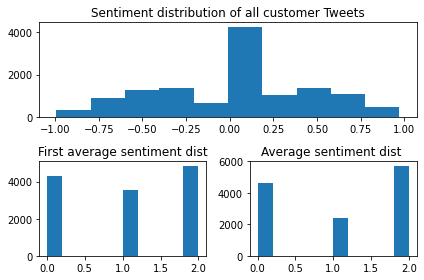

In [23]:
fig=plt.figure()

axs0=plt.subplot(211)
axs0.hist(customers["sentiment"])
axs0.set_title("Sentiment distribution of all customer Tweets")

axs1=plt.subplot(223)
axs1.hist(customer_first["first_sentiment"])
axs1.set_title("First average sentiment dist")

axs2=plt.subplot(224)
axs2.hist(customer_first["overall classification"])
axs2.set_title("Average sentiment dist ")


plt.tight_layout()
fig.savefig("sentiment_dist.png")
fig.show()

In [24]:
nltk.download('averaged_perceptron_tagger')

def encode_tweets(df):
  count=0
  encoded=[]
  embedding={}
  for scentence in df.tweet:
    encode=[]
    token=nltk.word_tokenize(scentence.lower())

    token=[ele for word_tuple in nltk.pos_tag(token) for ele in word_tuple ]

    for word in token:
      if word not in embedding:
        embedding[word]=count
        count+=1
      encode.append(embedding[word])
    encoded.append(encode)
  return (encoded)

#endoce the natural text into something the network will be able to read
encoded=encode_tweets(customer_first)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\annae\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [25]:
#replace the raw text with the encoded text
customer_first['encoded']=encoded

In [26]:
#train test split the data should be 80 20 by default 
#fit data into the models 

#split the data into train and test subsets
train_text, test_text, train_sent, test_sent=train_test_split(customer_first['encoded'], 
                                                              customer_first['overall classification'])
num_classes=3

train_text=train_text.values
test_text=test_text.values

#pad the text for uniformity on length
train_text=pad_sequences(train_text, maxlen=140)
test_text=pad_sequences(test_text, maxlen=140)

train_sent=train_sent.values
test_sent=test_sent.values
train_sent=keras.utils.to_categorical(train_sent)
test_sent=keras.utils.to_categorical(test_sent)

In [27]:
#model libraries 
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Dropout
from keras.layers import Conv1D, MaxPooling1D, Flatten, AveragePooling1D, Embedding
from keras.utils import to_categorical


In [28]:
word_dict=100000

num_labels=3
input_shape=test_text.shape
batch_size=100

#convolution
kernel_size=3
pool_size=2
filters=30

#lstm
lstm_sz_out=5

#training
dropout=0.2
epochs=10


model=Sequential()

model.add(Embedding(word_dict, input_shape[1], input_length=input_shape[1]))

model.add(Conv1D(filters=filters, kernel_size=kernel_size,
                activation='relu', input_shape=input_shape,
                padding='same'))
model.add(MaxPooling1D(pool_size))

model.add(Conv1D(filters=filters, kernel_size=kernel_size,
                activation='relu', input_shape=input_shape,
                padding='same'))
model.add(MaxPooling1D(pool_size))

model.add(Conv1D(filters=filters, kernel_size=kernel_size,
                activation='relu', input_shape=input_shape,
                padding='same'))
model.add(MaxPooling1D(pool_size))

model.add(Conv1D(filters=filters, kernel_size=kernel_size,
                activation='relu', input_shape=input_shape,
                padding='same'))
model.add(MaxPooling1D(pool_size))

model.add(LSTM(lstm_sz_out))
#model.add(Dense(3))

model.add(Flatten())
model.add(Dropout(dropout))

#softmax
model.add(Dense(num_labels))
model.add(Activation('softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 140, 140)          14000000  
                                                                 
 conv1d_4 (Conv1D)           (None, 140, 30)           12630     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 70, 30)           0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 70, 30)            2730      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 35, 30)           0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 35, 30)           

In [29]:
#compile the model
model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', metrics=['accuracy'])

In [30]:
model.fit(train_text, train_sent, batch_size=batch_size,epochs=epochs)

Epoch 1/10
96/96 [==============================] - 19s 173ms/step - loss: 1.0296 - accuracy: 0.4401
Epoch 2/10
96/96 [==============================] - 18s 190ms/step - loss: 0.8892 - accuracy: 0.5517
Epoch 3/10
96/96 [==============================] - 18s 187ms/step - loss: 0.7047 - accuracy: 0.7023
Epoch 4/10
96/96 [==============================] - 18s 185ms/step - loss: 0.4730 - accuracy: 0.8331
Epoch 5/10
96/96 [==============================] - 16s 170ms/step - loss: 0.3167 - accuracy: 0.9055
Epoch 6/10
96/96 [==============================] - 18s 185ms/step - loss: 0.2129 - accuracy: 0.9474
Epoch 7/10
96/96 [==============================] - 15s 158ms/step - loss: 0.1594 - accuracy: 0.9639
Epoch 8/10
96/96 [==============================] - 15s 155ms/step - loss: 0.1360 - accuracy: 0.9708
Epoch 9/10
96/96 [==============================] - 16s 164ms/step - loss: 0.1067 - accuracy: 0.9805
Epoch 10/10
96/96 [==============================] - 16s 169ms/step - loss: 0.0829 - accura

In [31]:
predicted=model.predict(test_text)

100/100 [==============================] - 1s 6ms/step


In [32]:
loss, accuracy=model.evaluate(test_text, test_sent, batch_size = batch_size)
print("CNN-LSTM Accuracy: %.1f%%" %(100.0*accuracy))

32/32 [==============================] - 1s 9ms/step - loss: 1.4700 - accuracy: 0.5970
CNN-LSTM Accuracy: 59.7%
